In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql import DataFrame

import pandas as pd
import numpy as np

# Set up SparkContext
conf = SparkConf().setMaster('local')
#sc = SparkContext(conf = conf)

spark = SparkSession.builder.master("local[8]").appName("cluster").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc = spark.sparkContext

In [3]:
PATH = "DATA/"
DATA = "malware_clean"

# file names :
f_var_control = "variables_control"
f_var_to_log = "variables_to_log_transform"
f_var_to_scale = "variables_to_scale"
f_var_to_mode_binary = "variables_to_modes_binary"

## Import data and variables

In [4]:
import pickle

with open (PATH + f_var_control, 'rb') as fp:
    var_control = pickle.load(fp)
    
with open (PATH + f_var_to_log, 'rb') as fp:
    var_to_log = pickle.load(fp)
    
with open (PATH + f_var_to_scale, 'rb') as fp:
    var_to_scale = pickle.load(fp)
    
with open (PATH + f_var_to_mode_binary, 'rb') as fp:
    var_to_mode_binary = pickle.load(fp)

In [5]:
print("Control variables          :",var_control)
print("Variables to log transform :", var_to_log)
print("Variables to scale         :",var_to_scale)
print("Variables to mode binary   :",var_to_mode_binary)

Control variables          : ['ID', 'md5', 'legitimate']
Variables to log transform : ['Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'AddressOfEntryPoint', 'BaseOfData', 'ImageBase', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'CheckSum', 'DllCharacteristics', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMeanVirtualsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNb', 'ResourcesNb', 'ResourcesMeanSize', 'ResourcesMinSize', 'ResourcesMaxSize', 'LoadConfigurationSize']
Variables to scale         : ['MajorLinkerVersion', 'MajorSubsystemVersion', 'SectionsNb', 'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'ImportsNbDLL', 'ResourcesMeanEntropy', 'ResourcesMinEntropy', 'ResourcesMaxEntropy']
Variables to mode binary   : ['Machine', 'SizeOfOptionalHeader', 'SizeOfUninitializedData', 'LoaderFlags', 'NumberOfRvaAndSizes']


In [6]:
%%time
dd_malware = spark.read.parquet(PATH + DATA)

Wall time: 4.92 s


In [7]:
%%time
dd_malware.show(5)

+------+--------------------+-------+--------------------+---------------+------------------+----------+---------------------+-----------------------+-------------------+----------+------------+---------------------------+---------------------------+-----------------+---------------------+---------------------+-----------+--------+------------------+-----------+-------------------+----------+-------------------+------------------+------------------+-------------------+------------------+-----------------+-----------------------+----------------------+---------------------+------------+---------+-----------+--------------------+-------------------+-------------------+-----------------+----------------+----------------+---------------------+----------+
|    ID|                 md5|Machine|SizeOfOptionalHeader|Characteristics|MajorLinkerVersion|SizeOfCode|SizeOfInitializedData|SizeOfUninitializedData|AddressOfEntryPoint|BaseOfData|   ImageBase|MajorOperatingSystemVersion|MinorOperatingSys

In [8]:
# There should be only one NA value in the dataFrame
dd_malware = dd_malware.fillna(0)

In [9]:
# The variable MACHINE is in a String Format, which suggests it is a categorical variable, nonetheless dominated by it's modal value.
from pyspark.sql.types import IntegerType
dd_malware = dd_malware.withColumn("Machine", dd_malware["Machine"].cast(IntegerType()))

## Split the DataFrame in Train, Test and Validation set


    - Train      -- > 70 %
    - Test       -- > 20 %
    - Validation -- > 10 %

In [10]:
set_sizes = [0.70,0.20,0.10]
dd_train, dd_test, dd_validation = dd_malware.randomSplit(set_sizes, seed=13)

In [11]:
print(dd_train.count())
print(dd_test.count())
print(dd_validation.count())

145172
41968
20791


## Data transformation 

In [13]:
# A neglect from the previous notebook... I did not published the mode values so I have to get them a second time... ah well...
def get_mode_value(dd,col):
    value = dd.select(col,'ID').groupby(col).count().orderBy(F.col('count').desc()).first()[0]
    return [col,value]

In [14]:
mode_values = [get_mode_value(dd_train,col) for col in var_to_mode_binary]
print(mode_values)

[['Machine', 332], ['SizeOfOptionalHeader', 224], ['SizeOfUninitializedData', 0], ['LoaderFlags', 0], ['NumberOfRvaAndSizes', 16]]


### Attempt at the first Spark MLLIB pipeline ! Transform the data 

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline

########################## Standard Scaling ##########################

# Transform into vectors
assemblers = [VectorAssembler(inputCols=[col], outputCol="VEC_" + col) for col in var_to_scale]
# Standard Scale
scalers = [StandardScaler(withStd=True, withMean=False, inputCol="VEC_" + col ,outputCol="SCALE_" + col) for col in var_to_scale]

########################## log Scaling ##########################

sqlTrans_LOG = [ SQLTransformer(statement="SELECT *, log10(" + col + ") AS LOG_" + col + " FROM __THIS__") for col in var_to_log]

########################## MODE Transformer Scaling ##########################

sqlTrans_mode = [SQLTransformer(statement="SELECT *, CASE WHEN " + col[0] + " = " + str(col[1]) + " then 1 else 0 end as MB_" + col[0] + " FROM __THIS__") for col in mode_values]


# Into Pipeline
pipeline = Pipeline(stages=assemblers + scalers + sqlTrans_LOG + sqlTrans_mode)

# Fit on training data
transformModel = pipeline.fit(dd_train)
transformModel.write().overwrite().save(PATH + "transforModel_Cluster")

# Transform TRAINING, TEST and VALIDATION
dd_train_scaled = transformModel.transform(dd_train)
dd_test_scaled = transformModel.transform(dd_test)
dd_validation_scaled = transformModel.transform(dd_validation)


In [18]:
# Define the columns to keep and the columns to perform the clustering
cols_to_keep = [col for col in dd_train_scaled.columns if (col[:3] == 'LOG' or col[:2] == 'MB' or col[:5] == 'SCALE' or col in var_control)]
cols_to_cluster = [col for col in dd_train_scaled.columns if (col[:3] == 'LOG' or col[:2] == 'MB' or col[:5] == 'SCALE')]
print(cols_to_keep)

['ID', 'md5', 'legitimate', 'SCALE_MajorLinkerVersion', 'SCALE_MajorSubsystemVersion', 'SCALE_SectionsNb', 'SCALE_SectionsMeanEntropy', 'SCALE_SectionsMinEntropy', 'SCALE_SectionsMaxEntropy', 'SCALE_ImportsNbDLL', 'SCALE_ResourcesMeanEntropy', 'SCALE_ResourcesMinEntropy', 'SCALE_ResourcesMaxEntropy', 'LOG_Characteristics', 'LOG_SizeOfCode', 'LOG_SizeOfInitializedData', 'LOG_AddressOfEntryPoint', 'LOG_BaseOfData', 'LOG_ImageBase', 'LOG_MajorOperatingSystemVersion', 'LOG_MinorOperatingSystemVersion', 'LOG_MajorImageVersion', 'LOG_MinorSubsystemVersion', 'LOG_SizeOfImage', 'LOG_CheckSum', 'LOG_DllCharacteristics', 'LOG_SectionsMeanRawsize', 'LOG_SectionsMinRawsize', 'LOG_SectionMaxRawsize', 'LOG_SectionsMeanVirtualsize', 'LOG_SectionsMinVirtualsize', 'LOG_SectionMaxVirtualsize', 'LOG_ImportsNb', 'LOG_ResourcesNb', 'LOG_ResourcesMeanSize', 'LOG_ResourcesMinSize', 'LOG_ResourcesMaxSize', 'LOG_LoadConfigurationSize', 'MB_Machine', 'MB_SizeOfOptionalHeader', 'MB_SizeOfUninitializedData', 'MB_

### Get the final forms of the dataframe prior to clustering

In [19]:
def final_dataframe_form(dd,cols,na_value):

    dd_final = dd.select(*tuple(cols))
    dd_final = dd_final.fillna(na_value)
    
    return dd_final

In [20]:
dd_train_final = final_dataframe_form(dd_train_scaled,cols_to_keep,-1)
dd_test_final = final_dataframe_form(dd_test_scaled,cols_to_keep,-1)
dd_validation_final = final_dataframe_form(dd_validation_scaled,cols_to_keep,-1)

## Clustering

    1 - Assess the optimal number of clusters according to the silhouette score
    2 - Perform a K-means clustering fitted on the training set then applied to all dataFrames
    3 - Display the clusters on a projected 2 first components of PCA vs the malicious/legit software

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Vectorize the features used for clustering
vecAssembler = VectorAssembler(inputCols=cols_to_cluster, outputCol="features")
dd_to_cluster = vecAssembler.transform(dd_train_final).select('ID','legitimate', 'features')
#df_kmeans.show()

silouhette_results = []
for i in np.arange(2,16):
    # Trains a k-means model.
    kmeans = KMeans().setK(int(i)).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(dd_to_cluster)

    # Make predictions
    predictions = model.transform(dd_to_cluster)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    #cost = model.computeCost(df_kmeans)
    
    print("Cluster no : ", i, " Silhouette with squared euclidean distance = " + str(silhouette))

    silouhette_results.append([i,silhouette])

Cluster no :  2  Silhouette with squared euclidean distance = 0.3910278422919131
Cluster no :  3  Silhouette with squared euclidean distance = 0.4322353409181172
Cluster no :  4  Silhouette with squared euclidean distance = 0.3321549118710413
Cluster no :  5  Silhouette with squared euclidean distance = 0.3729245667891567
Cluster no :  6  Silhouette with squared euclidean distance = 0.38211131806948834
Cluster no :  7  Silhouette with squared euclidean distance = 0.39184476883741726
Cluster no :  8  Silhouette with squared euclidean distance = 0.4382839089410009
Cluster no :  9  Silhouette with squared euclidean distance = 0.4466672709119888
Cluster no :  10  Silhouette with squared euclidean distance = 0.4420776657931265
Cluster no :  11  Silhouette with squared euclidean distance = 0.4562820940882336
Cluster no :  12  Silhouette with squared euclidean distance = 0.43833690822328375
Cluster no :  13  Silhouette with squared euclidean distance = 0.4496234700720545
Cluster no :  14  Sil

In [22]:
df_silhouette = pd.DataFrame(silouhette_results,columns=['n_cluster','silhouette_score'])

<AxesSubplot:xlabel='n_cluster'>

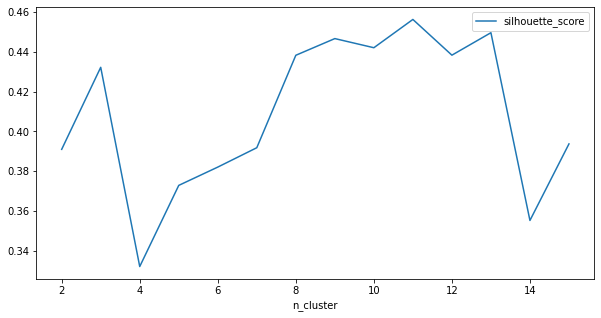

In [25]:
plt.rcParams['figure.figsize'] = [10,5]
df_silhouette.plot.line(x='n_cluster',y='silhouette_score')

In [24]:
df_silhouette

,n_cluster,silhouette_score
0,2,0.391028
1,3,0.432235
2,4,0.332155
3,5,0.372925
4,6,0.382111
5,7,0.391845
6,8,0.438284
7,9,0.446667
8,10,0.442078
9,11,0.456282


From the results above, we would be tempted to chose either 3 or any numbers between 8 and 13 clusters.

Although we have only 2 classes to predict, 3 clusters does not seem enough to represent adequately the number of software families.

Hence, according to the results, __8__ clusters is the next logical choice. 

### Clustering pipeline

In [26]:
n_clust = 8

# Vectorize
vecAssembler = VectorAssembler(inputCols=cols_to_cluster, outputCol="features")

# Kmeans
kmeans = KMeans().setK(n_clust).setSeed(1).setFeaturesCol("features")

# Into Pipeline
pipeline_cluster = Pipeline(stages=[vecAssembler,kmeans])

# Fit on training data
clusterModel = pipeline_cluster.fit(dd_train_final)
clusterModel.write().overwrite().save(PATH + "clusterModel_Cluster")



In [28]:
# Transform TRAINING, TEST and VALIDATION
dd_train_clust = clusterModel.transform(dd_train_final).withColumnRenamed('prediction', 'cluster_id')
dd_test_clust = clusterModel.transform(dd_test_final).withColumnRenamed('prediction', 'cluster_id')
dd_validation_clust = clusterModel.transform(dd_validation_final).withColumnRenamed('prediction', 'cluster_id')


### Let's take a look at the Pincipal Component Analysis and display the clustering results visually

In [29]:
max_var_num = len(dd_train_clust.select('features').first()[0])

In [30]:
from pyspark.ml.feature import PCA

pca = PCA(k=max_var_num, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(dd_train_clust)

train_pca = model_pca.transform(dd_train_clust)
#pred_3_pca.show(truncate=False)


In [31]:
var_exp = model_pca.explainedVariance

# get the cumulative variability explained by the principal components
cumul_vec = []
for i in np.arange(len(var_exp)):
    if i == 0:
        cumul_vec.append(var_exp[i])
    else:
        cumul_vec.append(cumul_vec[i-1] + var_exp[i])


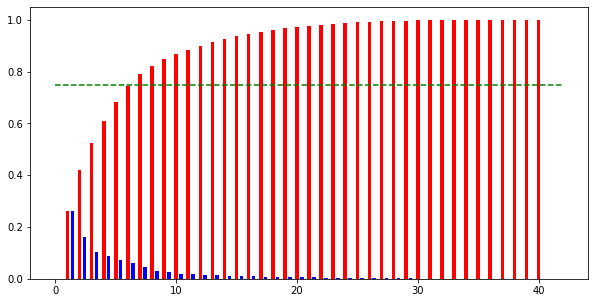

In [32]:
plt.bar(np.arange(1,len(var_exp)+1) + 0.4, var_exp,width=0.3,color='b')
plt.plot([0.75 for i in np.arange(0,len(var_exp)+3)], linestyle = 'dashed',linewidth = '1.5',color='g')
plt.bar(np.arange(1,len(cumul_vec)+1),cumul_vec,width = 0.3,color='r')
plt.show()

We see that the two first component only explain about 40% of the variability of the data. Hence reducing the dataset to only those two component will leave a lot of variability on the table

We can also see that over 75% of the variability explained is reached within the 7 first components.

In [ ]:
%%time
df_plot = train_pca.sample(0.4,seed=13).select('legitimate','cluster_id','pcaFeatures').toPandas()

In [39]:
df_plot2 = pd.merge(df_plot[['legitimate','cluster_id']],pd.DataFrame(df_plot['pcaFeatures'].tolist(), columns=["pca_" + str(i) for i in np.arange(1,max_var_num+1)]),left_index=True, right_index=True)

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

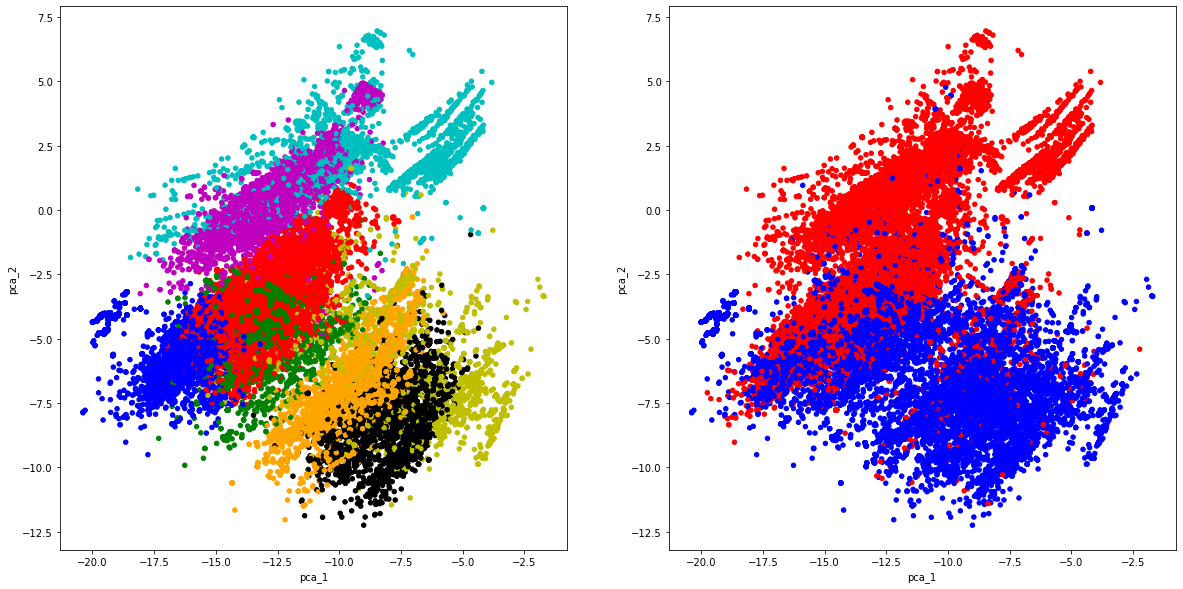

In [47]:
plt.rcParams['figure.figsize'] = [20,10]
fig, ax = plt.subplots(1,2)

color1 = df_plot2.cluster_id.map({0:'b', 1:'r', 2:'g', 3 : 'm', 4 : 'c', 5 : 'y', 6 : 'k', 7 : 'orange'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color1,ax=ax[0])

color2 = df_plot2.legitimate.map({0:'b', 1:'r'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color2,ax=ax[1])


Disclaimer : the two first components only capture about 40% of the energy. 

The graph on the right is interesting since it display that there exists a somewhat clear separation between the two classes according to the choice of variables and transformations made.

Although the clusters do not display clear cut delimitations, they do seem to capture the features that make a software high risk vs low risk. 
It appears relevant to include the cluster ID as a predictive features to the tree-based classifier and let it decide if the feature is important enough

## Predictive Modeling

    1 - GBT Classifier
    2 - Random Forest Classifier

In [48]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer

### The data must be reunited somehow... ###

dd_data = (dd_train_clust.withColumn('source',F.lit('train'))
                   .union(dd_test_clust.withColumn('source',F.lit('test')))
                   .union(dd_validation_clust.withColumn('source',F.lit('validation')))
          )



dd_data.select('ID','source').groupBy('source').count().show()

+----------+------+
|    source| count|
+----------+------+
|     train|145172|
|      test| 41968|
|validation| 20791|
+----------+------+



Somehow, I was not able to build the pipelines like displayed in the API docs... Nonetheless, I went straight to the predictive modeling

In [76]:
# Vectorize
dd_data1 = VectorAssembler(inputCols=['features','cluster_id'], outputCol="features_plus").transform(dd_data)
# Label Indexer 
labelIndexer = StringIndexer(inputCol="legitimate", outputCol="indexedLegitimate").fit(dd_data1).transform(dd_data1)
# Index Features
featureIndexer = VectorIndexer(inputCol="features_plus", outputCol="indexedFeatures", maxCategories=4).fit(labelIndexer).transform(labelIndexer)

dd_train_gbt = featureIndexer.filter(F.col('source') == 'train').drop('source')
dd_test_gbt = featureIndexer.filter(F.col('source') == 'test').drop('source')
dd_validation_gbt = featureIndexer.filter(F.col('source') == 'validation').drop('source')

# GBT Classifier
gbt = GBTClassifier(labelCol="indexedLegitimate", featuresCol="indexedFeatures", maxIter=50,maxDepth=10)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="indexedLegitimate", featuresCol="indexedFeatures", numTrees=50,maxDepth=10)

#pipeline_gbt = Pipeline(stages=[labelIndexer,featureIndexer,gbt])

# Train model.  This also runs the indexers.
model_gbt = gbt.fit(dd_train_gbt)

# Train the RandomForestClassifier
model_rf = rf.fit(dd_train_gbt)

# Make predictions with the GBT model
predictions_gbt = model_gbt.transform(dd_test_gbt)

# Make predictions with the Random Forest model
predictions_rf = model_rf.transform(dd_test_gbt)



In [77]:
# could have used the usual libraries, but... 
def get_perfo_results(pred_set):

    dd_results = pred_set.select('prediction','indexedLegitimate').groupby('prediction','indexedLegitimate').count()
    dd_results.cache()
    # This is tricky... legitimate = 1 is legit no ? so should be our negative. So for the rest, we consider our positives to be legitimate = 0, the malicious software.
    fp = dd_results.filter((F.col('prediction') == 0) & (F.col('indexedLegitimate') == 1)).select('count').first()[0]
    tp = dd_results.filter((F.col('prediction') == 0) & (F.col('indexedLegitimate') == 0)).select('count').first()[0]
    fn = dd_results.filter((F.col('prediction') == 1) & (F.col('indexedLegitimate') == 0)).select('count').first()[0]
    tn = dd_results.filter((F.col('prediction') == 1) & (F.col('indexedLegitimate') == 1)).select('count').first()[0]

    return dd_results, fp, tp, fn, tn


In [78]:
def display_results(fp, tp, fn, tn):
    
    print("False positive rate (%) : ", "{:.2%}".format(fp/(fp+tp)))
    print("False negative rate (%) : ", "{:.2%}".format(fn/(fn+tn)))
    print("Accuracy rate (%)       : ", "{:.2%}".format(1-(fp+fn)/(fp+fn+tp+tn)))

## GBT Results

In [74]:
# GBT : with maxIter=50 and max_depth=10
dd_results_gbt, fp, tp, fn, tn = get_perfo_results(predictions_gbt)
dd_results_gbt.show()

+----------+-----------------+-----+
|prediction|indexedLegitimate|count|
+----------+-----------------+-----+
|       1.0|              1.0|13285|
|       0.0|              1.0|  340|
|       1.0|              0.0|  239|
|       0.0|              0.0|28104|
+----------+-----------------+-----+



In [75]:
display_results(fp, tp, fn, tn)

False positive rate (%) :  1.20%
False negative rate (%) :  1.77%
Accuracy rate (%)       :  98.62%


This is not bad at all ! On a single try !

## Random Forest Results

In [79]:
# RF : with 50 trees, maxDepth=10
dd_results_rf, fp, tp, fn, tn = get_perfo_results(predictions_rf)
dd_results_rf.show()

+----------+-----------------+-----+
|prediction|indexedLegitimate|count|
+----------+-----------------+-----+
|       1.0|              1.0|13115|
|       0.0|              1.0|  510|
|       1.0|              0.0|  355|
|       0.0|              0.0|27988|
+----------+-----------------+-----+



In [80]:
display_results(fp, tp, fn, tn)

False positive rate (%) :  1.79%
False negative rate (%) :  2.64%
Accuracy rate (%)       :  97.94%


It is not bad, but GBT has a better performance

## Let's analyse the Random Forest Feature Importance and see if there is an equivalent for GBT (not in doc...)

### Random Forest Feature importance

In [81]:
feature_importance = model_rf.featureImportances

In [119]:
features_name = predictions_rf.columns[3:-8] + ['cluster_id']

d_fi = {'feature_name' : features_name, 'feature_importance' : list(feature_importance)}
df_feature_importance = pd.DataFrame(d_fi,columns=['feature_name','feature_importance'])
df_feature_importance.sort_values('feature_importance',ascending=False).head(15)

,feature_name,feature_importance
10,LOG_Characteristics,0.153039
16,LOG_MajorOperatingSystemVersion,0.132012
15,LOG_ImageBase,0.129933
32,LOG_ResourcesMinSize,0.102505
1,SCALE_MajorSubsystemVersion,0.046432
40,cluster_id,0.045554
8,SCALE_ResourcesMinEntropy,0.045504
18,LOG_MajorImageVersion,0.038167
30,LOG_ResourcesNb,0.033489
5,SCALE_SectionsMaxEntropy,0.031120


<AxesSubplot:xlabel='feature_name'>

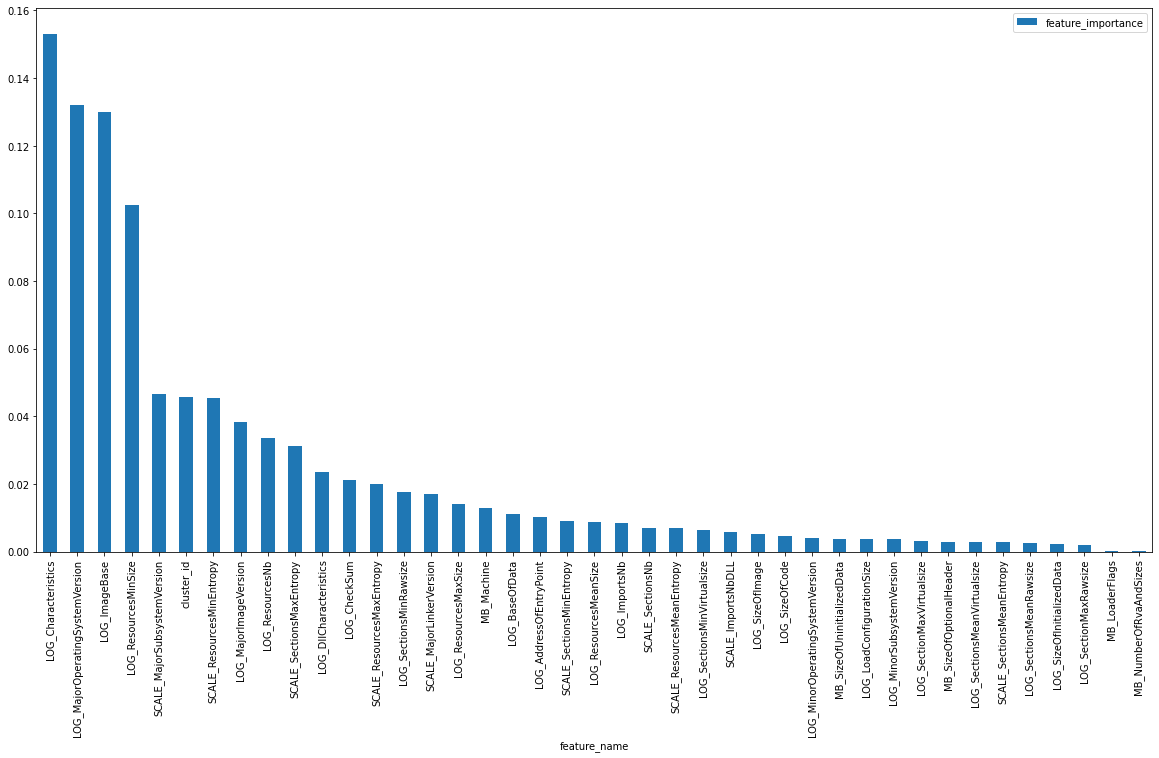

In [120]:
df_feature_importance.sort_values('feature_importance',ascending=False).plot.bar(x='feature_name',y='feature_importance')

### GBT Feature importance

In [122]:
feature_importance_gbt = model_gbt.featureImportances

In [123]:
features_name = predictions_gbt.columns[3:-8] + ['cluster_id']

d_fi = {'feature_name' : features_name, 'feature_importance' : list(feature_importance_gbt)}
df_feature_importance_gbt = pd.DataFrame(d_fi,columns=['feature_name','feature_importance'])
df_feature_importance_gbt.sort_values('feature_importance',ascending=False).head(15)

,feature_name,feature_importance
15,LOG_ImageBase,0.544728
16,LOG_MajorOperatingSystemVersion,0.052575
40,cluster_id,0.050468
32,LOG_ResourcesMinSize,0.039804
5,SCALE_SectionsMaxEntropy,0.034126
10,LOG_Characteristics,0.015591
29,LOG_ImportsNb,0.015011
2,SCALE_SectionsNb,0.014706
18,LOG_MajorImageVersion,0.012400
21,LOG_CheckSum,0.012339


<AxesSubplot:xlabel='feature_name'>

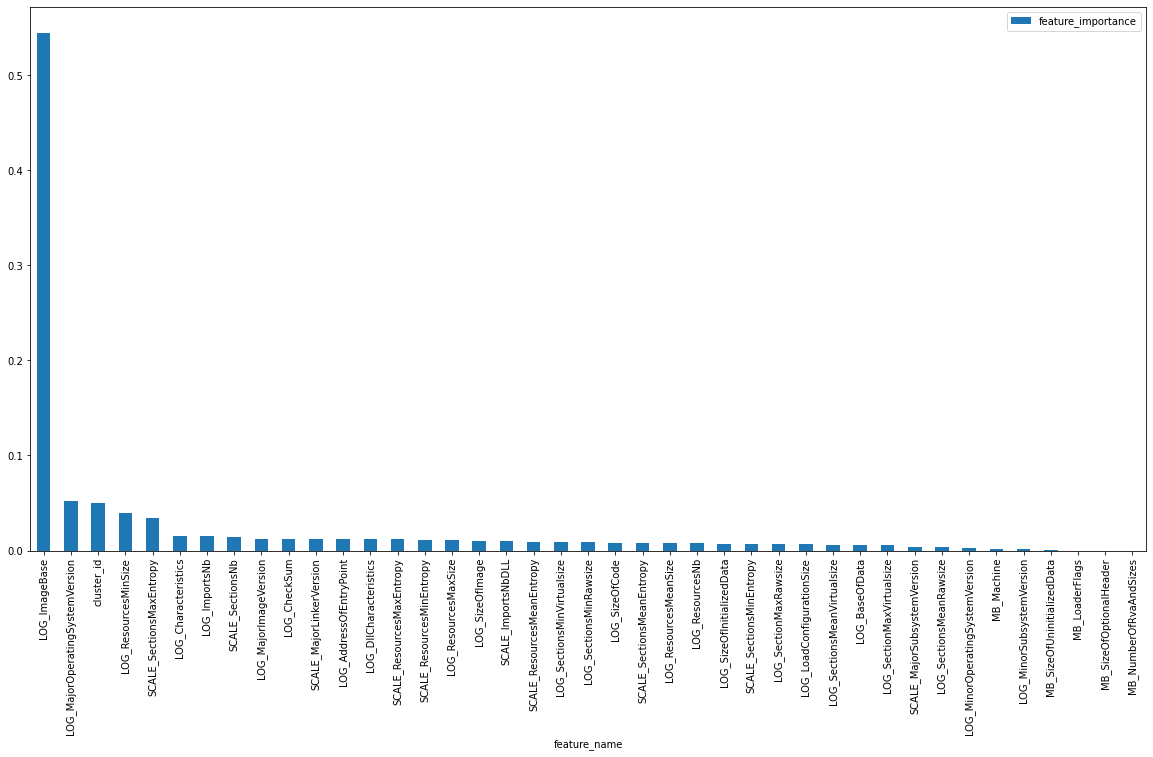

In [124]:
df_feature_importance_gbt.sort_values('feature_importance',ascending=False).plot.bar(x='feature_name',y='feature_importance')

### Residue of the very first try, results

In [215]:
# with maxIter=20 and max_depth=25
model_gbt.transform(dd_test_gbt).select('prediction','indexedLegitimate').groupby('prediction','indexedLegitimate').count().show()

+----------+-----------------+-----+
|prediction|indexedLegitimate|count|
+----------+-----------------+-----+
|       1.0|              1.0|13227|
|       0.0|              1.0|  398|
|       1.0|              0.0|  356|
|       0.0|              0.0|27987|
+----------+-----------------+-----+



In [214]:
model_gbt.write().overwrite().save(PATH + "malware_model_gbt")
model_rf.write().overwrite().save(PATH + "malware_model_rf")

## Residue

In [104]:
# Let's pick 3 - 7 - 12 clusters and ... see !

dd_to_cluster.cache()

def kmeans_cluster(dd, n_clust):
    kmeans = KMeans().setK(n_clust).setSeed(1).setFeaturesCol("features")
    model_kmeans = kmeans.fit(dd)

    # Make predictions
    predictions = model_kmeans.transform(dd)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    
    return silhouette, predictions, model_kmeans

In [105]:
silhouette_3, pred_3, model_kmeans = kmeans_cluster(dd_to_cluster, 8)

In [97]:
pred_3.show()

+---+----------+--------------------+----------+
| ID|legitimate|            features|prediction|
+---+----------+--------------------+----------+
|  1|         1|[1.38596067435553...|         1|
| 43|         1|[1.38596067435553...|         1|
| 47|         1|[8.31576404613322...|         1|
| 54|         1|[1.38596067435553...|         1|
| 66|         1|[1.55920575864998...|         4|
| 69|         1|[1.73245084294442...|         1|
| 74|         1|[1.03947050576665...|         6|
| 76|         1|[1.38596067435553...|         3|
| 88|         1|[8.31576404613322...|         0|
| 89|         1|[2.42543118012219...|         1|
|102|         1|[1.38596067435553...|         1|
|107|         1|[1.38596067435553...|         4|
|112|         1|[1.38596067435553...|         1|
|117|         1|[1.38596067435553...|         1|
|130|         1|[1.90569592723886...|         1|
|138|         1|[1.55920575864998...|         0|
|142|         1|[2.07894101153330...|         1|
|145|         1|[2.4

In [100]:
df_plot2 = pd.merge(df_plot[['legitimate','prediction']],pd.DataFrame(df_plot['pcaFeatures'].tolist(), columns=['pca_1','pca_2']),left_index=True, right_index=True)

## Display with 7 clusters

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

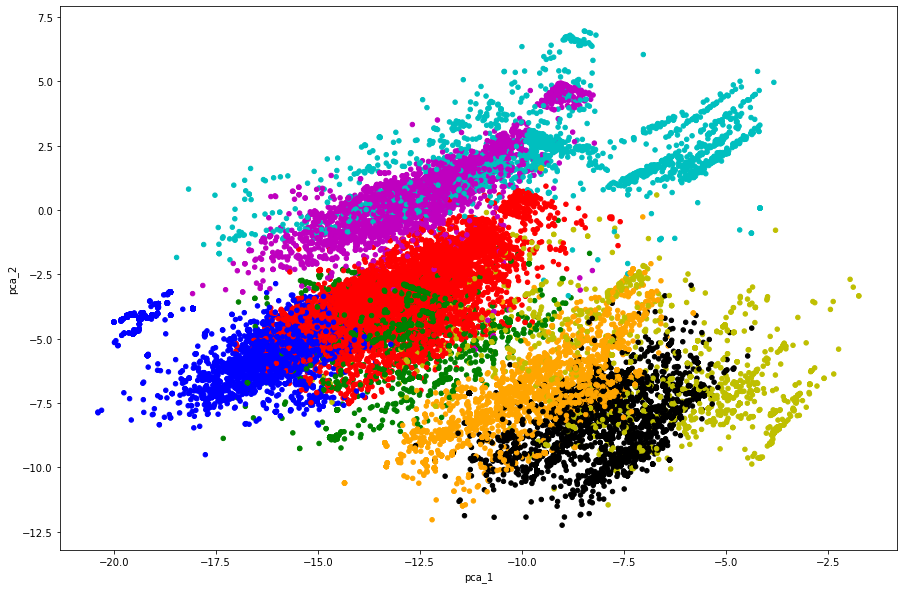

In [101]:
color = df_plot2.prediction.map({0:'b', 1:'r', 2:'g', 3 : 'm', 4 : 'c', 5 : 'y', 6 : 'k', 7 : 'orange'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color)

## Display of the hack vs legit

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

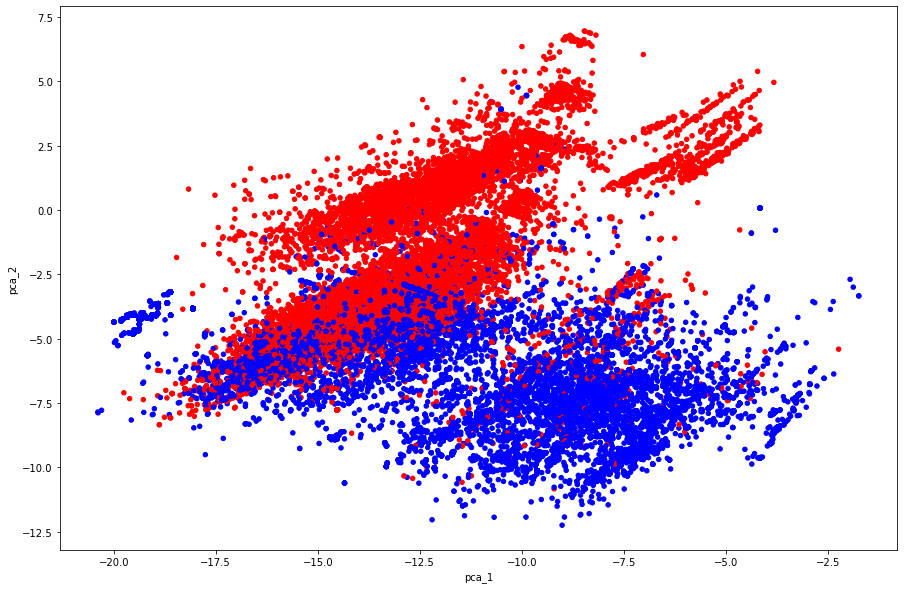

In [94]:
color = df_plot2.legitimate.map({0:'b', 1:'r', 2:'g'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color)

In [ ]:
# On test set 

vecAssembler = VectorAssembler(inputCols=cols_to_cluster, outputCol="features")
dd_test_cluster = vecAssembler.transform(dd_validation_final).select('ID','legitimate', 'features')

pred_test = model_kmeans.transform(dd_test_cluster)
pred_test_pca = model_pca.transform(pred_test)

df_plot = pred_test_pca.select('legitimate','prediction','pcaFeatures').toPandas()
df_plot2 = pd.merge(df_plot[['legitimate','prediction']],pd.DataFrame(df_plot['pcaFeatures'].tolist(), columns=['pca_1','pca_2']),left_index=True, right_index=True)

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

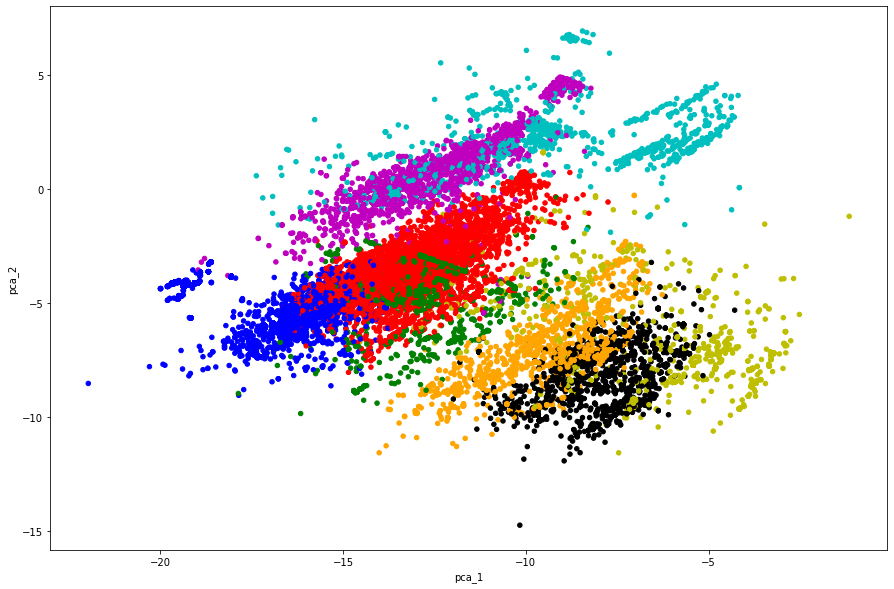

In [111]:
color = df_plot2.prediction.map({0:'b', 1:'r', 2:'g', 3 : 'm', 4 : 'c', 5 : 'y', 6 : 'k', 7 : 'orange'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color)

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

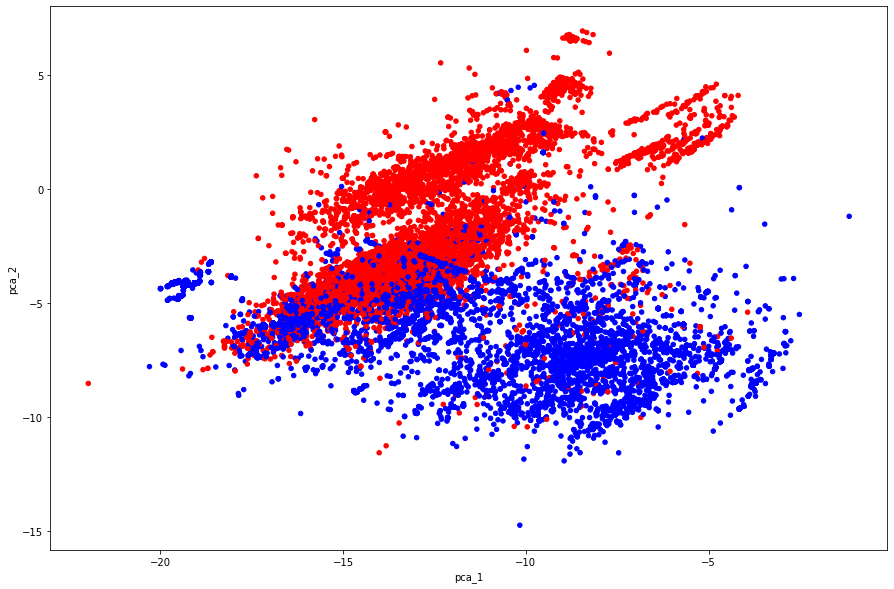

In [112]:
color = df_plot2.legitimate.map({0:'b', 1:'r', 2:'g'})
df_plot2.plot.scatter(x='pca_1', y='pca_2', c=color)

In [119]:
model_pca.explainedVariance

DenseVector([0.2601, 0.1611])